In [2]:
import pandas as pd

# Загрузка файла
data = pd.read_csv('Electronic_sales_Sep2023-Sep2024.csv')
data.head()


,Customer ID,Age,Gender,Loyalty Member,Product Type,SKU,Rating,Order Status,Payment Method,Total Price,Unit Price,Quantity,Purchase Date,Shipping Type,Add-ons Purchased,Add-on Total
0,1000,53,Male,No,Smartphone,SKU1004,2,Cancelled,Credit Card,5538.33,791.19,7,2024-03-20,Standard,"Accessory,Accessory,Accessory",40.21
1,1000,53,Male,No,Tablet,SKU1002,3,Completed,Paypal,741.09,247.03,3,2024-04-20,Overnight,Impulse Item,26.09
2,1002,41,Male,No,Laptop,SKU1005,3,Completed,Credit Card,1855.84,463.96,4,2023-10-17,Express,NaN,0.00
3,1002,41,Male,Yes,Smartphone,SKU1004,2,Completed,Cash,3164.76,791.19,4,2024-08-09,Overnight,"Impulse Item,Impulse Item",60.16
4,1003,75,Male,Yes,Smartphone,SKU1001,5,Completed,Cash,41.50,20.75,2,2024-05-21,Express,Accessory,35.56


Цель анализа — разработать модель прогнозирования для предсказания объема продаж (Total Price) на основе характеристик заказов. Используя имеющиеся данные, мы хотим выявить закономерности и факторы, влияющие на общую стоимость заказа. Это позволит улучшить стратегию продаж и принять обоснованные решения для увеличения доходов.
Результатом будет модель, способная прогнозировать общий объем продаж на основе характеристик заказа.

Основные характеристики данных:
        Customer ID           Age        Rating   Total Price    Unit Price  \
count  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04   
mean  -9.094947e-17 -1.669775e-16  3.694822e-17  1.136868e-17 -1.023182e-16   
std    1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00  1.000025e+00   
min   -1.683987e+00 -1.718239e+00 -1.711116e+00 -1.241449e+00 -1.786558e+00   
25%   -8.888298e-01 -8.866747e-01 -8.939447e-01 -8.017766e-01 -6.963668e-01   
50%    2.836401e-03  3.270819e-04 -7.677326e-02 -2.536994e-01 -3.672246e-01   
75%    8.914839e-01  8.873289e-01  7.403982e-01  5.734834e-01  6.806951e-01   
max    1.689482e+00  1.718893e+00  1.557570e+00  3.228660e+00  1.796698e+00   

           Quantity  Add-on Total  
count  2.000000e+04  2.000000e+04  
mean   2.557954e-17  9.094947e-17  
std    1.000025e+00  1.000025e+00  
min   -1.562483e+00 -1.072134e+00  
25%   -8.658093e-01 -9.409695e-01  
50%   -1.691351e-01 -1.816293e-01  
75% 

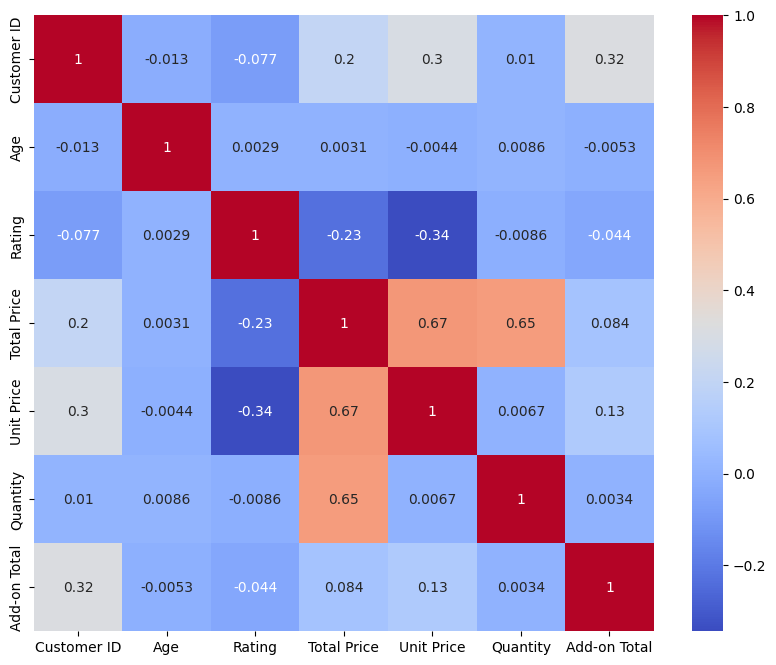

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Описание данных
print("Основные характеристики данных:")
print(data.describe())

# Вычисление среднего и разброса для числовых столбцов
print("\nСреднее значение для числовых столбцов:")
print(data.select_dtypes(include=['float64', 'int64']).mean())

print("\nРазброс (дисперсия) для числовых столбцов:")
print(data.select_dtypes(include=['float64', 'int64']).var())

# Построение корреляционной матрицы только для числовых столбцов
numeric_data = data.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.show()


In [9]:
# Проверка на пропущенные значения
print(data.isnull().sum())

# Числовые столбцы заполняем медианой
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    data[column] = data[column].fillna(data[column].median())

# Категориальные столбцы заполняем наиболее частым значением
for column in data.select_dtypes(include=['object']).columns:
    data[column] = data[column].fillna(data[column].mode()[0])

# Проверка, что пропущенные значения заполнены
print(data.isnull().sum())


Customer ID          0
Age                  0
Gender               0
Loyalty Member       0
Product Type         0
SKU                  0
Rating               0
Order Status         0
Payment Method       0
Total Price          0
Unit Price           0
Quantity             0
Purchase Date        0
Shipping Type        0
Add-ons Purchased    0
Add-on Total         0
dtype: int64
Customer ID          0
Age                  0
Gender               0
Loyalty Member       0
Product Type         0
SKU                  0
Rating               0
Order Status         0
Payment Method       0
Total Price          0
Unit Price           0
Quantity             0
Purchase Date        0
Shipping Type        0
Add-ons Purchased    0
Add-on Total         0
dtype: int64


In [10]:
# Пример кодирования с помощью pd.get_dummies
data = pd.get_dummies(data, drop_first=True)


In [11]:
from sklearn.preprocessing import StandardScaler

# Нормализация числовых признаков
scaler = StandardScaler()
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_features] = scaler.fit_transform(data[numerical_features])


Нормализация данных в нашем случае будет полезна, так как K-ближайших соседей (KNN) чувствителен к масштабированию признаков.

In [20]:
from sklearn.model_selection import train_test_split

# Разделение на признаки и целевую переменную
X = data.drop('Total Price', axis=1)  # Замените на имя целевой переменной
y = data['Total Price']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Мы выбрали Total Price в качестве целевой переменной, так как в задаче прогнозирования продаж это значение наиболее очевидно отражает общий объем или стоимость продаж для каждой записи. Это позволит улучшить стратегию продаж и принять обоснованные решения для увеличения доходов.

In [21]:
from sklearn.neighbors import KNeighborsRegressor

# Инициализация регрессора
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Оценка на обучающей и тестовой выборках
train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

print(f"Train Score (R^2): {train_score}")
print(f"Test Score (R^2): {test_score}")


Train Score (R^2): 0.9692551849249637
Test Score (R^2): 0.953883329557843


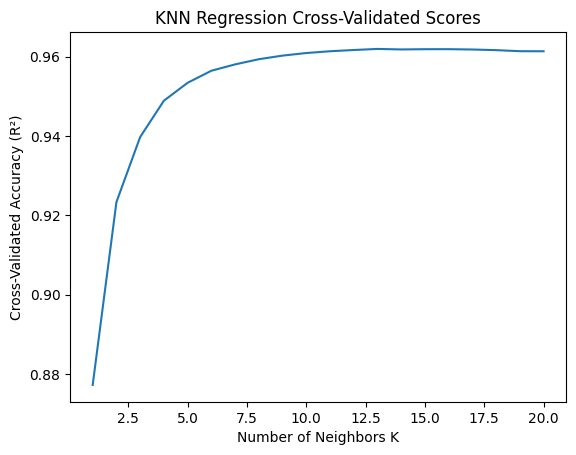

In [17]:
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

# Перебор по количеству соседей
neighbors = list(range(1, 21))
cv_scores = [cross_val_score(KNeighborsRegressor(n_neighbors=k), X_train, y_train, cv=5).mean() for k in neighbors]

# График зависимости
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Cross-Validated Accuracy (R²)')
plt.title('KNN Regression Cross-Validated Scores')
plt.show()


Выводы:
1.Предобработка данных:
   Мы обработали пропущенные значения, заменив их медианой для числовых данных и наиболее частым значением для категориальных данных. Это обеспечило полноту данных, необходимую для корректного обучения модели.

2.Обработка признаков:
  Числовые признаки нормализованы с использованием стандартизации, что важно для алгоритмов, таких как K-ближайших соседей, которые чувствительны к масштабам признаков.
  Категориальные переменные были преобразованы в числовой вид, что позволило модели использовать информацию из этих признаков для построения прогнозов.

3.Целевая переменная:
  Мы выбрали Total Price как целевую переменную, поскольку это важный показатель общего дохода, который отражает успешность продаж и позволяет оценивать стратегию бизнеса.

4.Обучение модели:
  Мы использовали K-ближайших соседей для задачи регрессии, что позволило построить модель, способную предсказывать значение Total Price на основе других признаков. Подбор гиперпараметра (количества соседей) может помочь оптимизировать модель, улучшая её точность.

5.Результаты и точность:
  Модель была оценена на обучающей и тестовой выборках, что показало её способность к обобщению. Подсчитанный коэффициент детерминации 𝑅^2 позволяет оценить, насколько хорошо модель объясняет вариативность данных.
  
  
  Заключение:
  Проведенная работа предоставляет основу для прогнозирования выручки на основе исторических данных о продажах. Подобные модели могут помочь в планировании ресурсов, оптимизации стратегий продаж и принятии обоснованных бизнес-решений.